# 1. Library

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import os
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from PIL import Image
from keras.preprocessing import image
from keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

from tensorflow.keras import models
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization

from sklearn.metrics import classification_report, confusion_matrix

# 2. Mount the Google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Read the dataframe

In [ ]:
dahlia_df_train = pd.read_csv('/content/drive/My Drive/MasterProject/dahlianame_train.xlsx',dtype=str)
dahlia_df_validation = pd.read_csv('/content/drive/My Drive/MasterProject/dahlianame_validation.xlsx',dtype=str)

# Labels

In [ ]:
labels_dahlia = dahlia_df_train['Class_name'].unique()
len(labels_dahlia)

59

In [ ]:
dahlianame_train = glob('/content/drive/My Drive/MasterProject/split_data/Dahlia/train/*/*.*')
len(dahlianame_train)

1054

In [ ]:
labels_dahlia_v = dahlia_df_validation['Class_name'].unique()
len(labels_dahlia_v)

59

# 8. Data augmentation Genus

In [ ]:
image_size = 224
batch_size = 10
n_epochs = 20

In [ ]:
train_datagen_dahlia = ImageDataGenerator(rescale = 1.0/255.,                                            
                                            horizontal_flip = True,                                            
                                            zoom_range=0.1,                                            
                                            rotation_range=15,
                                            fill_mode="constant",
                                            cval=0)
                                   

train_generator_dahlia = train_datagen_dahlia.flow_from_dataframe(dataframe=dahlia_df_train,
                                                    directory=None,
                                                    x_col="File_path",
                                                    y_col="Class_name",
                                                    shuffle = True,
                                                    batch_size=batch_size,
                                                    target_size=(image_size,image_size),
                                                    class_mode='categorical')
validation_datagen_dahlia = ImageDataGenerator(rescale = 1.0/255.)

validation_generator_dahlia = validation_datagen_dahlia.flow_from_dataframe(dataframe=dahlia_df_validation,
                                                         directory=None,
                                                         x_col="File_path",
                                                         y_col="Class_name",
                                                         shuffle = False, 
                                                         batch_size=batch_size,
                                                         target_size=(image_size,image_size), 
                                                         class_mode='categorical')

Found 1054 validated image filenames belonging to 59 classes.
Found 170 validated image filenames belonging to 59 classes.


# 9. Download the pretrained algorithms from TensorFlow.

In [ ]:
pretrained_model1 = tf.keras.applications.DenseNet201(input_shape=(image_size,image_size,3),
                                                      include_top=False,
                                                      weights='imagenet',
                                                      pooling='avg')
pretrained_model1.trainable = False
model_dahlia_DenseNet201 = models.Sequential()
model_dahlia_DenseNet201.add(pretrained_model1)
model_dahlia_DenseNet201.add(Flatten())
model_dahlia_DenseNet201.add(Dense(units=512, activation='relu'))
model_dahlia_DenseNet201.add(Dropout(0.5))
model_dahlia_DenseNet201.add(BatchNormalization())
model_dahlia_DenseNet201.add(Dense(units=256, activation='relu'))
model_dahlia_DenseNet201.add(Dropout(0.5))
model_dahlia_DenseNet201.add(BatchNormalization())
model_dahlia_DenseNet201.add(Dense(len(labels_dahlia), activation='softmax'))

# Read the table for saving the result in it.

In [ ]:
filepath_metrics = Path('/content/drive/My Drive/MasterProject/metrics.xlsx')
df_metrics = pd.read_csv(filepath_metrics,dtype=str)

# 10. Compile the Model

In [ ]:
dahlia_algorithms_DenseNet201 = {'DenseNet201 model for Dahlia': model_dahlia_DenseNet201}

In [ ]:
def algorithms_dahlia(name,model): 
  global df_metrics 

  model.compile(loss='categorical_crossentropy', 
              optimizer=tf.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(5)])
  
  his_name = model.fit(train_generator_dahlia,
              epochs=n_epochs,
              steps_per_epoch=len(dahlianame_train)/batch_size,
              validation_data=validation_generator_dahlia
              )
  
  fig, ax = plt.subplots(1, 2, figsize=(15, 5))
  ax = ax.ravel()
  
  for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(his_name.history[met])
    ax[i].plot(his_name.history['val_' + met])
    ax[i].set_title('Training and validation {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['training', 'validation'])

# For every epoch, append losses to dataframe 
  df_metrics.loc[len(df_metrics.index)] = [name, 
              round((np.amax(his_name.history['accuracy'])*100),2),
              round((np.amax(his_name.history['top_k_categorical_accuracy'])*100),2),
              round((np.amax(his_name.history['val_accuracy'])*100),2),
              round((np.amax(his_name.history['val_top_k_categorical_accuracy'])*100),2),
              round(np.amin(his_name.history['loss']),2),
              round(np.amin(his_name.history['val_loss']),2)]     

  return model

# Run, Save the Models and plot the Result

Epoch 1/20
105/105 [==============================] - 382s 3s/step - loss: 4.5112 - accuracy: 0.0323 - top_k_categorical_accuracy: 0.1300 - val_loss: 3.6051 - val_accuracy: 0.1353 - val_top_k_categorical_accuracy: 0.3824
Epoch 2/20
105/105 [==============================] - 38s 363ms/step - loss: 4.1004 - accuracy: 0.0626 - top_k_categorical_accuracy: 0.2211 - val_loss: 3.2850 - val_accuracy: 0.2294 - val_top_k_categorical_accuracy: 0.5471
Epoch 3/20
105/105 [==============================] - 38s 362ms/step - loss: 3.7990 - accuracy: 0.1053 - top_k_categorical_accuracy: 0.2979 - val_loss: 3.0637 - val_accuracy: 0.2471 - val_top_k_categorical_accuracy: 0.5706
Epoch 4/20
105/105 [==============================] - 39s 365ms/step - loss: 3.5226 - accuracy: 0.1414 - top_k_categorical_accuracy: 0.3710 - val_loss: 2.8747 - val_accuracy: 0.2824 - val_top_k_categorical_accuracy: 0.5588
Epoch 5/20
105/105 [==============================] - 38s 355ms/step - loss: 3.3724 - accuracy: 0.1575 - top_k

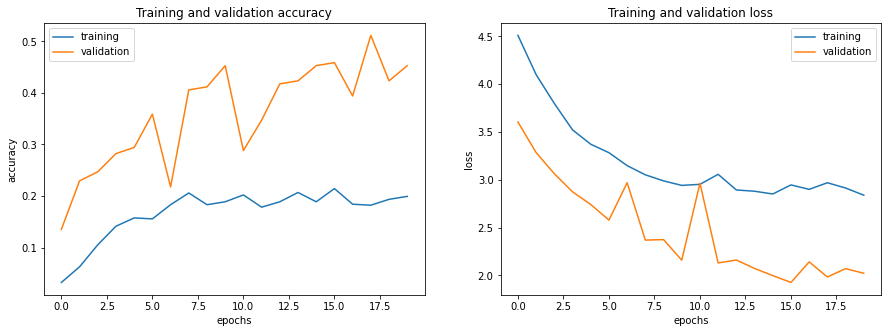

In [ ]:
for key, value in dahlia_algorithms_DenseNet201.items():
  model_cultivar = algorithms_dahlia(key,value)
  model_cultivar.save('/content/drive/My Drive/MasterProject/model/' + key + '.h5')

In [ ]:
print(df_metrics)

                Name of a Model  Training Accuracy, %  \
0  DenseNet201 model for Dahlia                 21.44   

   Top 5 Training accuracy, %  Validation accuracy, %  \
0                       56.93                   51.18   

   Top 5 Validation accuracy, %  Training loss  Validation loss  
0                         84.71           2.84             1.93  


In [ ]:
filepath_metrics = Path('/content/drive/My Drive/MasterProject/metrics.xlsx')
df_metrics.to_csv(filepath_metrics,index=False)

# Confusion Matrix

In [ ]:
Y_pred = model_dahlia_DenseNet201.predict_generator(validation_generator_dahlia, validation_generator_dahlia.samples // validation_generator_dahlia.batch_size + 5)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator_dahlia.classes, y_pred))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


Confusion Matrix
[[1 0 1 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]]


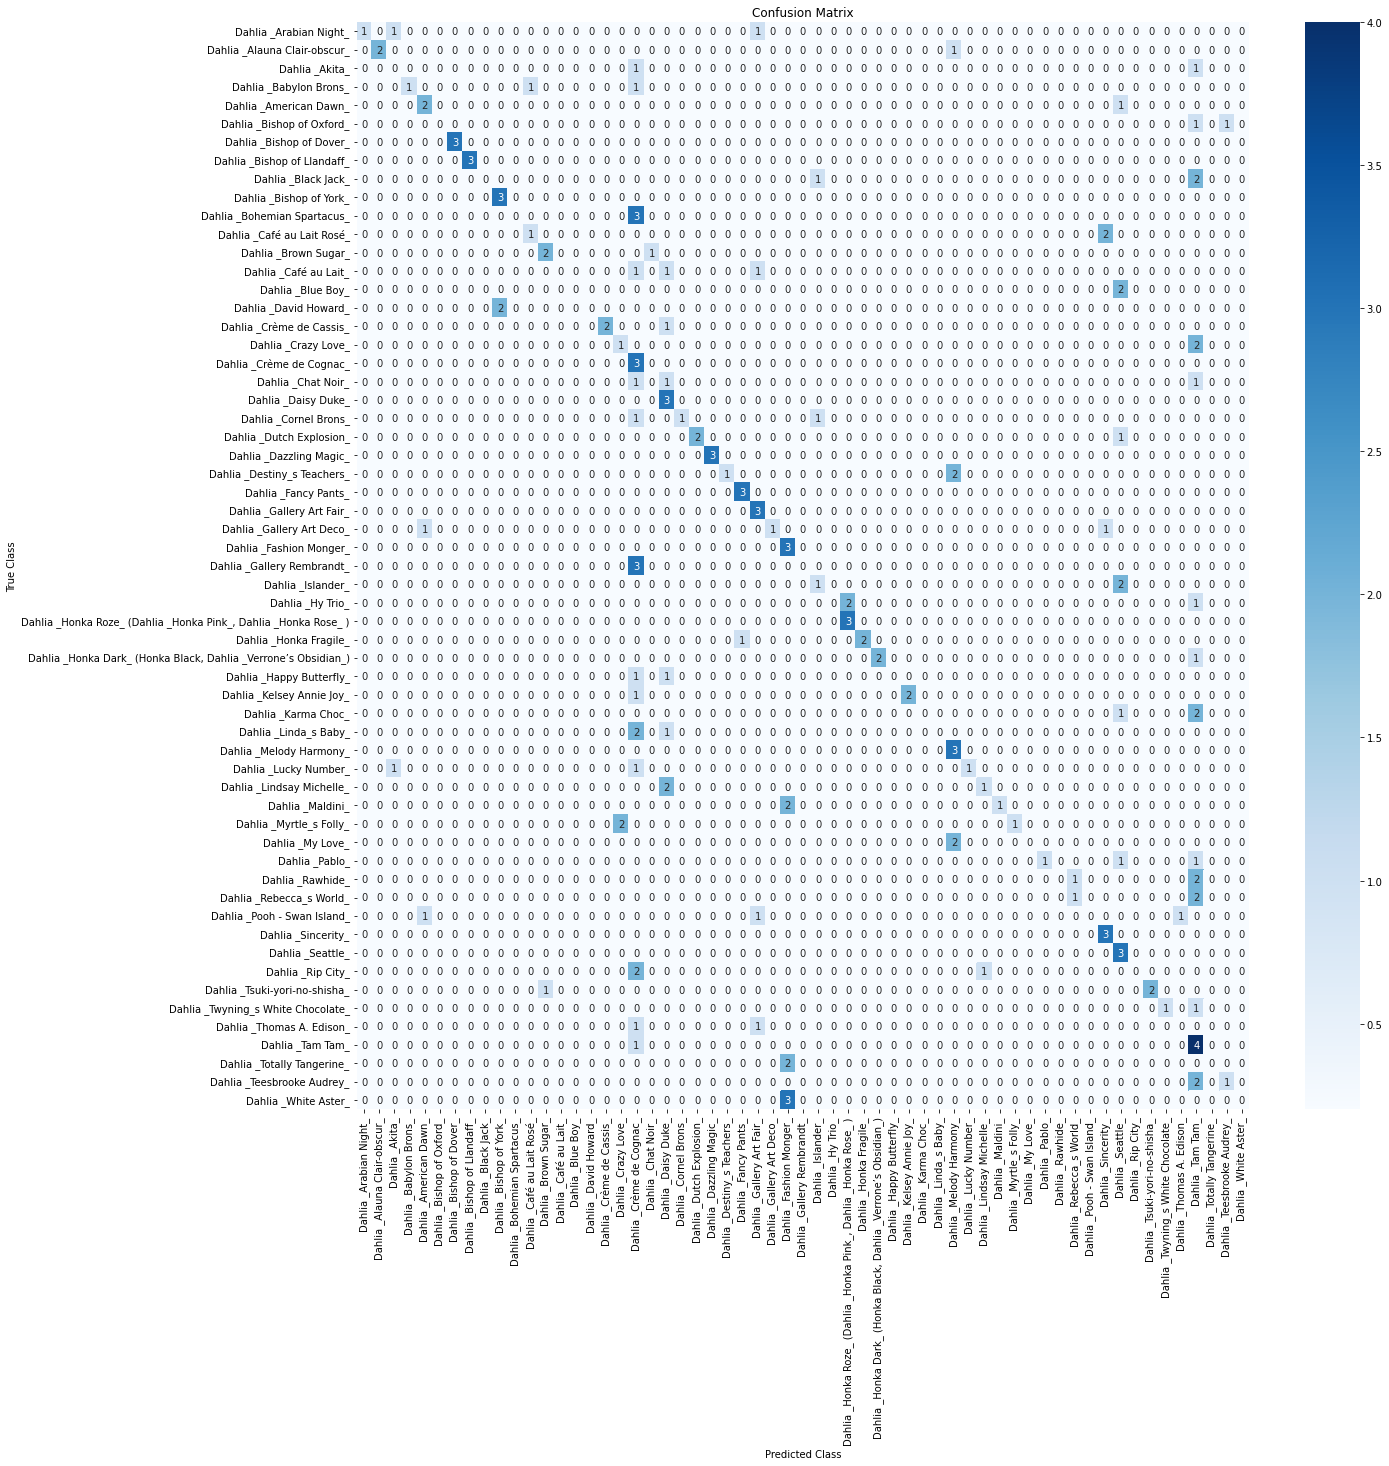

In [ ]:
cm = confusion_matrix(validation_generator_dahlia.classes, y_pred)
plt.figure(figsize=(20,20))
sns.heatmap(cm,xticklabels=labels_dahlia, yticklabels=labels_dahlia, annot=True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

# Classification Report

In [ ]:
target_names = list(train_generator_dahlia.class_indices.keys()) 
print(classification_report(validation_generator_dahlia.classes, y_pred, target_names=target_names))

                                                                 precision    recall  f1-score   support

                                                 Dahlia _Akita_       1.00      0.33      0.50         3
                                   Dahlia _Alauna Clair-obscur_       1.00      0.67      0.80         3
                                         Dahlia _American Dawn_       0.00      0.00      0.00         2
                                         Dahlia _Arabian Night_       1.00      0.33      0.50         3
                                         Dahlia _Babylon Brons_       0.50      0.67      0.57         3
                                       Dahlia _Bishop of Dover_       0.00      0.00      0.00         2
                                    Dahlia _Bishop of Llandaff_       1.00      1.00      1.00         3
                                      Dahlia _Bishop of Oxford_       1.00      1.00      1.00         3
                                        Dahlia _Bishop

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Prediction on test dataset

Load the image

In [ ]:
#image_path = "/content/drive/My Drive/MasterProject/test/Helleborus/Helleborus _Penny_s Pink_/hellebore-pennys-pink.jpg"
image_path = "/content/drive/My Drive/MasterProject/test/Dahlia/Dahlia _Alauna Clair-obscur_/Dahlia 'Alauna Clair-obscur'.jpg"
#img_path = "/content/drive/My Drive/MasterProject/test/Dahlia/Dahlia _American Dawn_/dahlia-american-dawn-2.jpg"

In [ ]:
test_images = ["/content/drive/My Drive/MasterProject/test/Dahlia/Dahlia _Alauna Clair-obscur_/Dahlia 'Alauna Clair-obscur'.jpg",
               "/content/drive/My Drive/MasterProject/test/Helleborus/Helleborus _Penny_s Pink_/hellebore-pennys-pink.jpg",
               "/content/drive/My Drive/MasterProject/test/Dahlia/Dahlia _American Dawn_/dahlia-american-dawn-2.jpg"
               ]

Create the function for coding the image

In [ ]:
def load_image(img_path, show=True):
  global name
  name = img_path.split("/")[-2]
  print("The true name is ",name)

  img = image.load_img(img_path, target_size=(image_size, image_size))
  img_tensor = image.img_to_array(img)                    # (height, width, channels)
  img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
  img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

  if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

  return img_tensor

load the table for saving the result

In [ ]:
filepath_result = Path('/content/drive/My Drive/MasterProject/result.xlsx')
df_result = pd.read_csv(filepath_result)

The true name is  Dahlia _Alauna Clair-obscur_


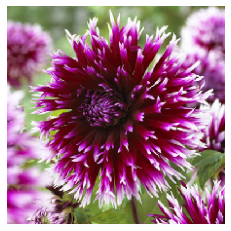

DenseNet201 model for Dahlia
Dahlia _Alauna Clair-obscur_ 75.11 %
Dahlia _Destiny_s Teachers_ 15.17 %
Dahlia _Melody Harmony_ 7.54 %
Dahlia _My Love_ 1.62 %
Dahlia _Honka Dark_ (Honka Black, Dahlia _Verrone’s Obsidian_) 0.43 %
It is  Dahlia _Alauna Clair-obscur_ with accuracy  75.11 % for DenseNet201 model for Dahlia


In [ ]:
# LAST prediction for set of images and set of models for cultivar name
new_image = load_image(image_path)

for key, value in dahlia_algorithms_DenseNet201.items():
  print(key)

# check prediction
  validation_generator_dahlia.reset()
  pred = model_dahlia_DenseNet201.predict(new_image)
  predictions = np.argmax(pred, axis=1)

  result_dahlia = {labels_dahlia[i]: pred[0][i] for i in range(len(labels_dahlia))}
  sort_result_dahlia = sorted(result_dahlia.items(), key=lambda x: x[1], reverse=True)
  for i in sort_result_dahlia[:5]:
    print(i[0], round((i[1]*100),2), "%")
    df_result.loc[len(df_result.index)] = [key,
                                         name,
                                         i[0],
                                         round((i[1]*100),2)]

print("It is ",labels_dahlia[predictions[0]], "with accuracy ", round((np.amax(pred)*100),2), "% for " + key)

In [ ]:
df_result

,Model,True Name,Name of a Plant,%
0,DenseNet201 model for Dahlia,Dahlia _Alauna Clair-obscur_,Dahlia _Alauna Clair-obscur_,75.11
1,DenseNet201 model for Dahlia,Dahlia _Alauna Clair-obscur_,Dahlia _Destiny_s Teachers_,15.17
2,DenseNet201 model for Dahlia,Dahlia _Alauna Clair-obscur_,Dahlia _Melody Harmony_,7.54
3,DenseNet201 model for Dahlia,Dahlia _Alauna Clair-obscur_,Dahlia _My Love_,1.62
4,DenseNet201 model for Dahlia,Dahlia _Alauna Clair-obscur_,"Dahlia _Honka Dark_ (Honka Black, Dahlia _Verr...",0.43


In [ ]:
filepath_result = Path('/content/drive/My Drive/MasterProject/result.xlsx')
df_result.to_csv(filepath_result,index=False)

# Check the train and validation images after generator

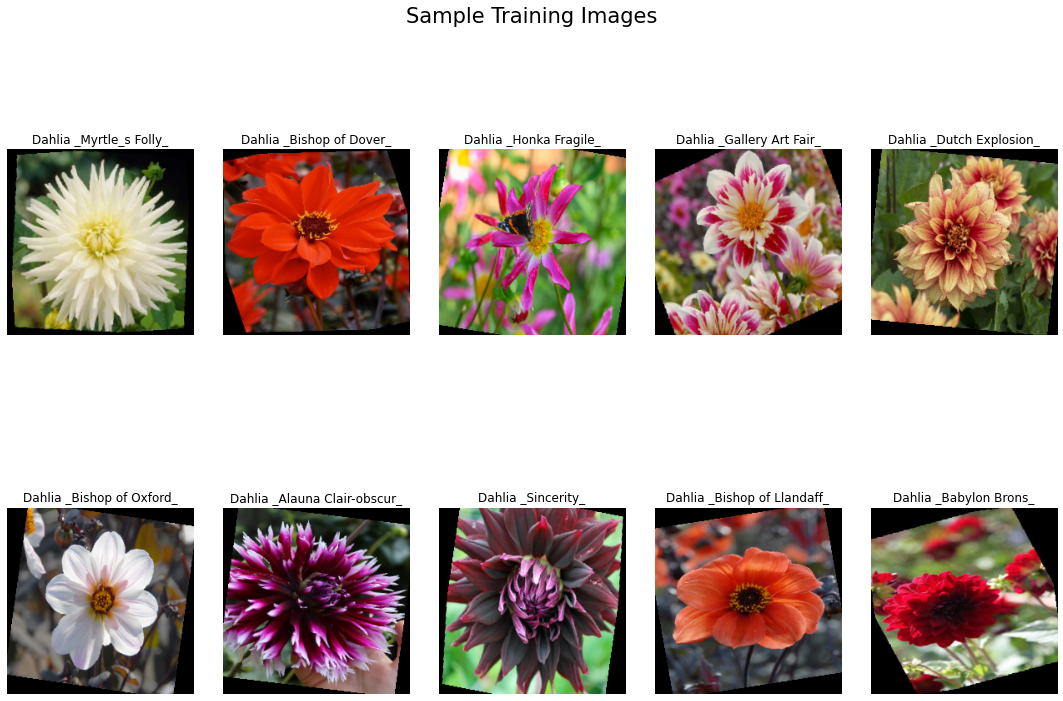

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels_dahlia[np.argmax(train_generator_dahlia[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator_dahlia[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

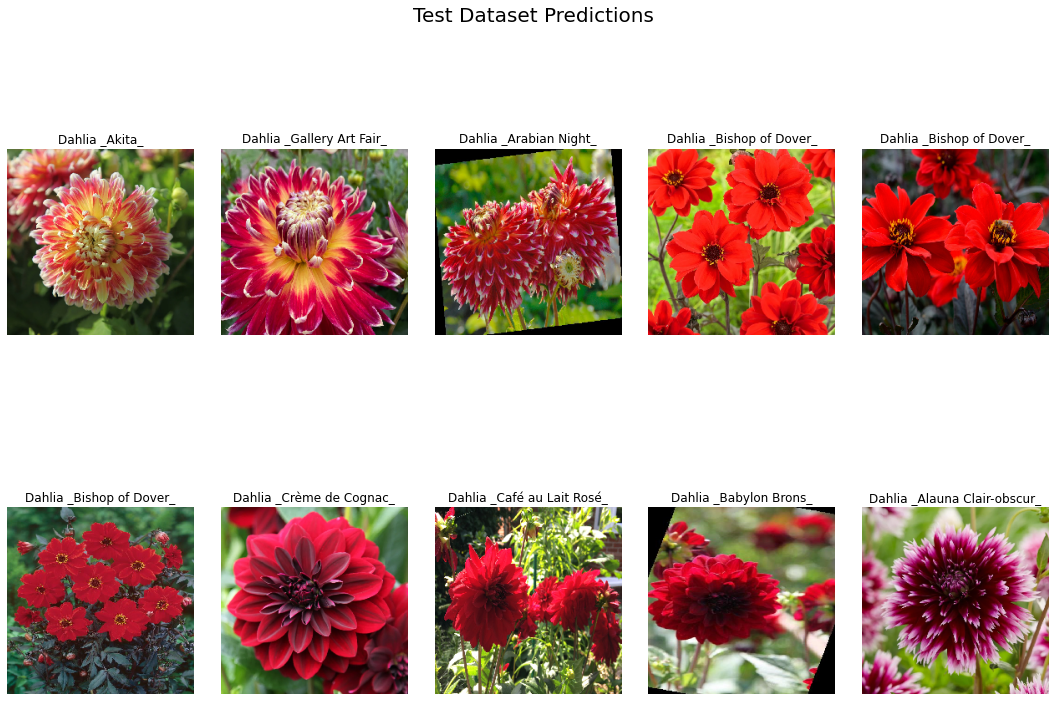

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0
predictions = model_dahlia_DenseNet201.predict(validation_generator_dahlia)
for i in range(2):
    for j in range(5):
        predicted_label = labels_dahlia[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(validation_generator_dahlia[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()